# Machine Learning met Python

In dit onderdeel kijken we naar de een fractie van de mogelijkheden die Python biedt voor machine learning. De Open Source Software community heeft een grote rol gespeeld in het neerzetten van een interface, bovenop numpy en scipy, met een hoop eenheid en gebruiksgemak. Let wel, vanwege het open source karakte is et nog wel eens aan verandering onderhevig. Over het algmeen worden deze veranderingen aangekondigd met warnings ruim voordat de oude code niet meer werkt, maar houd er rekening mee dat als je meer dan een jaar niet met softwrae hebt gewerkt en de packages update, dat code dan wellicht niet meer helemaal werkt (het gaat altijd om details).

We zullen kijken naar supervised en unsupervised learning technieken met scikit-learn. Aan het eind kijken we ook nog even aar de mogelijkheden van Tensorflow (met Keras frontend) voor (diepe) neurale netwerken.

scikitlearn (te importeren als sklearn) bevat allerlei functionaliteiten in allerlei packages. Bijvoorbeeld:
- datasets: het verkrijgen van data
- linear_models: bevat lineaire modellen
- neighbors: nearest neighbor modellen
- svm: Support Vector Machines
- model_selection: functionaliteit om modellen te beoordelen
- tree: beslisbomen etc.
- preprocessing: voorbereiden van data

In [1]:
# ALgemene imports. Imports die specifiek horen bij de voorbeelden worden ter plekke ingeladen, voor de duidleijkheid van het voorbeeld.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

## Supervised machine learning

Supervised learning is het trainen van een algoritme om een *bekend antwoord* te reproduceren en komt voornamelijk in 2 smaken:
- Classificatie: het voorspellen van labels, op basis van andere data features.
- Regressie: het voorspellen van een getalswaarde voor ene grootheid op basis van andere data features.

### Logistische regressie als voorbeeld

Hier zullen we kijke naar een uitgewerkt voorbeeld van de logistische regressie. We houden het bij een simpel voorbeeld dat we makkelijk kunnen visualiseren. In de package "sklearn.datasets" zit "makeblobs" waarbij je blobs van data maakt die bij elkaar horen en een label krijgen. Logistische regressie is een lineair model voor classificatie van die labels en zit dus in "sklearn.linear_model".

X, aantal samples en aantal features: (100, 2)
y aantal samples: (100,)

Eerste 5 samples:
 [[ 4.21850347  2.23419161]
 [ 0.90779887  0.45984362]
 [-0.27652528  5.08127768]
 [ 0.08848433  2.32299086]
 [ 3.24329731  1.21460627]]

Eerste 5 labels: [1 1 0 0 1] 

De twee blobs, kleur correspondeert met het label:


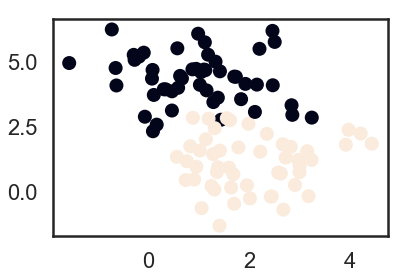

In [2]:
from sklearn.datasets import make_blobs

# Maak twee blobs. X krijgt 2D coordinaten en y is een label voor bij welke blob de data hoort.
X, y = make_blobs(centers=2, random_state=0)

print('X, aantal samples en aantal features:', X.shape)
print('y aantal samples:', y.shape)

print('\nEerste 5 samples:\n', X[:5, :])
print('\nEerste 5 labels:', y[:5], '\n')

# En in een simpel plaatje
plt.scatter(X[:,0], X[:,1], c=y);
print("De twee blobs, kleur correspondeert met het label:")

Omdat het wel blijkt dat alleen de y-variabele in dat plaatje echt belangrijk is, kijken we eerst naar een voorbeeld waarin we alleen het label proberen te voorspellen als functie van y:

In [3]:
x  =  np.reshape(X[:,1], (-1, 1))          # Die truc met reshape is nodig omdat de regresse een tweedimensionale data container verwacht. Zie de -1!
print(np.shape(x))
print(np.shape(y))

(100, 1)
(100,)


In [4]:
# Laadt en initialiseer de lineaire regressie
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

Op dit moment bestaat er een instantie van een logistisch regressie-object. Deze heeft nog niks gedaan, maar er zijn wel een hoop dingen die nu gedaan kunnen worden. In de eerste plaats kun je een model fitten, met de "fit()" methode. Nadat dat gedaan is kun je het model ook evalueren. "score()" is de methode die je daarvoor gebruikt en in het geval van een logistische regressie krijg je dan de fractie van labels die je goed hebt voorspeld:

In [5]:
classifier.fit(x, y)
classifier.score(x,y)  # R**2

0.94

Je kunt ook de logistische functies die je daadwerkelijk hebt gefit bekijken. Voor elk punt krijg je een probability dat het datapunt een bepaald label heeft. Deze krijg je door de methode "predict_proba()" met te roepen op een array getallen. Als je twee mogelijke labels had resulteert dat dus in een array met net zoveel rijen als je inputvector en twee kolommen (waarvan de waarden optellen tot 1):

(100, 2)


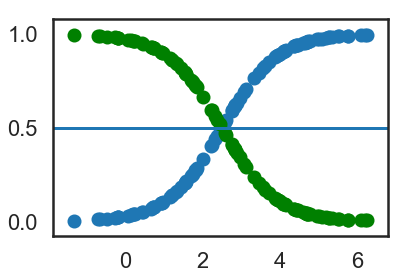

In [6]:
# De waarschijnlijkheden van de beide labels (tellen uiteraard beide op tot 1)
print(np.shape(classifier.predict_proba(x)))
plt.scatter(x, classifier.predict_proba(x)[:,0])
plt.scatter(x, classifier.predict_proba(x)[:,1], c='green')
plt.axhline(y=0.5);

De logistische regressie, zoals vele andere modellen, kan een willekeurig aantal dimensies aan in je inputdata, en kan ook meer dan twee labels voorspellen. HIer zie je het voorbeeld uitgewerkt voor de oorspronkelijke dataset met twee dimensies in de inputarray, en nog steeds twee mogelijke labels.

0.92
(100, 2)


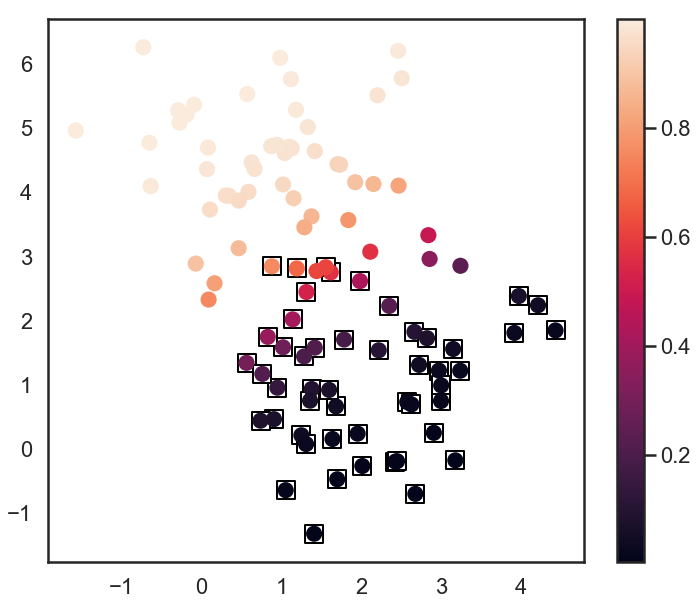

In [7]:
# Nu even op de 2D dataset. Helpt dat?
classifier.fit(X, y)
print(classifier.score(X,y))

print(np.shape(classifier.predict_proba(X)))
plt.figure(figsize=(12, 10))
plt.scatter(X[y==1,0], X[y==1,1], s=300, marker='s', c='white', edgecolors='black')
plt.scatter(X[:,0], X[:,1], c=classifier.predict_proba(X)[:,0], s=200)
plt.colorbar();

## Unsupervised machine learning
Unsupervised machine learning is een klasse van modellen die je kunt trainen, waarbij *niet* van te voren een juist antwoord bekend is. Wat valt er dan te trainen? Ook unsupervised machine learning komt in grofweg in twee varianten:
- Dimensiereductie en patroonherkenning: in datasets met zeer veel dimensies zit vaak wel het een en ander aan structuur. Deze modellen zijn ervoor om je te helpen zulke structuren te vinden, maar ook om je dataset te transformeren naar een dataset met veel minder dimensies, zonder dat je daarmee veel "inzicht" over je data verliest.
- Clustering en segmentatie: in grote datasets wil het nog wel eens gebeuren dat verschillende observaties clusteren in kliekjes. Deze klasse van modellen is ervoor om zulke kliekjes op te sporen.

### k-means clustering als een voorbeeld van unsupervised learning
Als voorbeeld kijken we naar een veelgebruikt clustering-algoritme: k-means. We maken opnieuw gebruik van make_blobs om ditmaal 3 blobs te maken, die we met behulp van k-means willen terugvinden.


(100, 2)


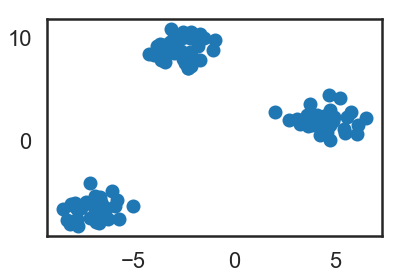

In [8]:
X, y = make_blobs(random_state=42)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1]);

KMeans vinden we in sklearn.cluster en bij het maken van de instantie kun je meegeven hoeveel clusters er moeten worden gevonden. Vaak weet je dat vantevoren niet. In het geval van unsupervised learning is het veelal experimenteren tot je de juiste "hyperparameters" (de parameters die een model sturen) hebt gevonden:

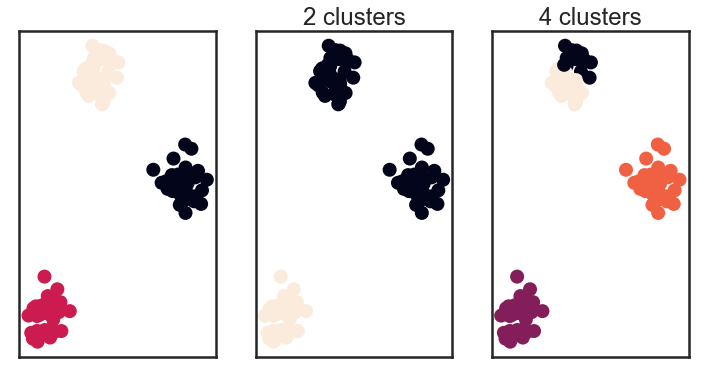

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.title("2 clusters")
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("4 clusters")
plt.xticks([])
plt.yticks([]);


Ook bij het voorkomen van clusters van verschillende afmetingen (of compactheid) kan KMeans in de problemen komen. Blijf experimenteren!

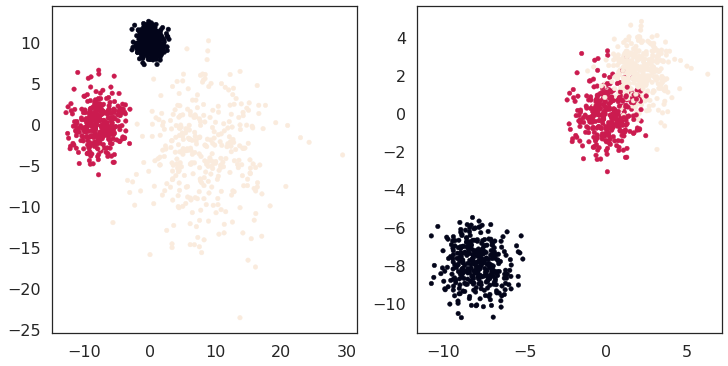

In [10]:
X1, y1 = make_blobs(random_state=101, cluster_std=[1, 2, 5], centers=[[0, 10],[-8, 0], [8,-4]], n_samples=1000, )
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=20)
X2, y2 = make_blobs(random_state=101, centers=[[-8, -8],[0, 0], [2,2]], n_samples=1000, )
plt.subplot(122)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=20);

## Neurale netwerken

Neurale netwerken zijn eigenlijk een soort kettingreactie van "logistische regressie"-achtige modellen via hidden layers (zie de presentatie).
Zolang we scikit-learn's Multi-layer Perceptron gebruiken kunnen we het hele netwerk in 1 keer definieren.

### De MNIST hand-written digits dataset
Als voorbeeld kijken we naar de MNIST hand-written 

In [12]:
digitfile  = 'data/digits_train_sample.csv'

digits = pd.read_csv(digitfile, sep=',')
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.datasets import fetch_mldata
# Data wordt subdirectory data opgeslagen, en gedownload als deze nog niet bestaat.
mnist = fetch_mldata("MNIST original", data_home='./data/')  

X, y = mnist.data / 255., mnist.target

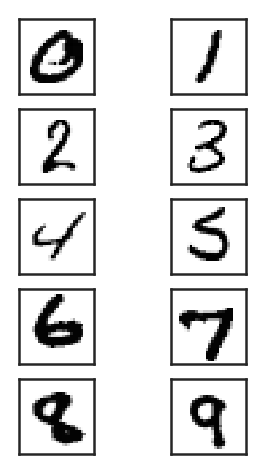

In [26]:
# Zoals je wellicht opvalt zijn er 784 pixels, eat toevallig 28**2, de "shape" van de plaatjes 
imsize = 28

# Bekijk van elk getal een random voorbeeld. Als je deze cell meerdere keren uitvoert krijg je steeds een nieuwe serie. 
plt.figure(figsize=[5, 8])
for target in range(10):
    deze = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(X[deze]), [imsize, imsize])
    pp = plt.subplot(5, 2, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

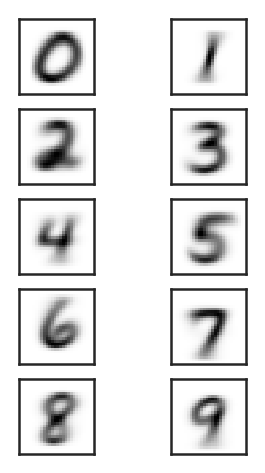

In [29]:
# We kunnen ook het "gemiddelde plaatje" van elk cijfer laten zien.
# Dit komt min of meer overeen met hetgeen we het model gaan trainen!

plt.figure(figsize=[5, 8])
for target in range(10):
    number = np.reshape( X[np.where(y==target)].mean(axis=0) , [imsize, imsize])
    pp = plt.subplot(5, 2, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

In [30]:
labels = y
features = X

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)
clf = LogisticRegression()

In [32]:
clf.fit(xtr, ytr)
print(clf.score(xtr, ytr))
print(clf.score(x, y))

0.929469387755102
0.917952380952381


/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


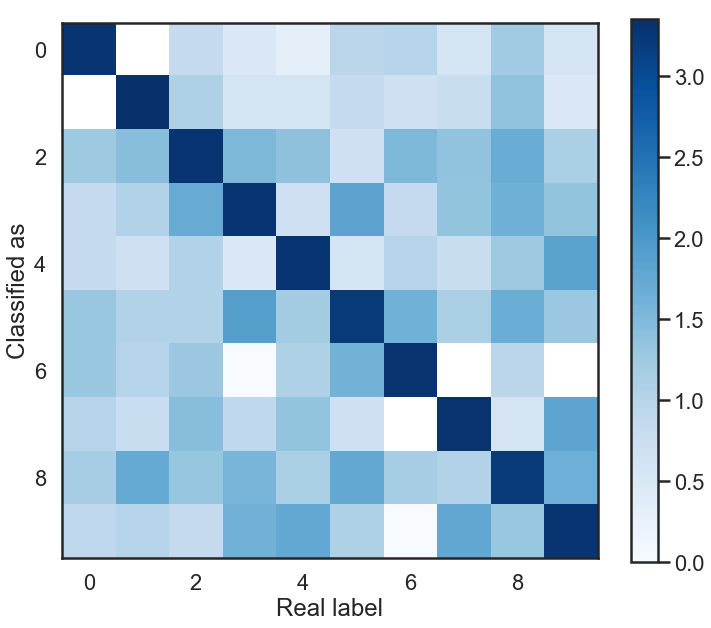

In [33]:
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar()

In [34]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [35]:
mlp.fit(xtr, ytr)
mlp.score(x, y)

0.9751904761904762

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 50, 50), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=50, tol=1e-4, random_state=1,
                    learning_rate_init=.1 )

mlp.fit(xtr, ytr)
mlp.score(x, y)

Iteration 1, loss = 0.37936988
Iteration 2, loss = 0.11948885
Iteration 3, loss = 0.08235241
Iteration 4, loss = 0.06600295
Iteration 5, loss = 0.05326562
Iteration 6, loss = 0.04365812
Iteration 7, loss = 0.03482985
Iteration 8, loss = 0.03153139
Iteration 9, loss = 0.02279448
Iteration 10, loss = 0.02351146
Iteration 11, loss = 0.02055967
Iteration 12, loss = 0.02117752
Iteration 13, loss = 0.01820354
Iteration 14, loss = 0.01529617
Iteration 15, loss = 0.01819637
Iteration 16, loss = 0.01626478
Iteration 17, loss = 0.00890520
Iteration 18, loss = 0.00610710
Iteration 19, loss = 0.00876675
Iteration 20, loss = 0.01155455
Iteration 21, loss = 0.01149641
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


0.9758571428571429

## Tensorflow via Keras

Definitie per laag in het netwerk. Meer vrijheid, dus meer werk.

In [37]:
import tensorflow as tf

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(xtr, ytr, epochs=10)
print(model.evaluate(xtr, ytr))
model.evaluate(x, y)

Epoch 1/10
49000/49000 [==============================] - 10s 200us/step - loss: 0.2534 - acc: 0.9271
Epoch 2/10
49000/49000 [==============================] - 11s 231us/step - loss: 0.1030 - acc: 0.9677
Epoch 3/10
49000/49000 [==============================] - 9s 174us/step - loss: 0.0706 - acc: 0.9778
Epoch 4/10
49000/49000 [==============================] - 9s 193us/step - loss: 0.0551 - acc: 0.9821
Epoch 5/10
49000/49000 [==============================] - 10s 194us/step - loss: 0.0421 - acc: 0.9864
Epoch 6/10
49000/49000 [==============================] - 11s 215us/step - loss: 0.0345 - acc: 0.9885
Epoch 7/10
49000/49000 [==============================] - 11s 224us/step - loss: 0.0311 - acc: 0.9894
Epoch 8/10
49000/49000 [==============================] - 11s 223us/step - loss: 0.0278 - acc: 0.9909
Epoch 9/10
49000/49000 [==============================] - 11s 232us/step - loss: 0.0227 - acc: 0.9927
Epoch 10/10
49000/49000 [==============================] - 3s 57us/step
[0.032157831

[0.1341309543965451, 0.9713333333333334]

In [26]:
auto_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(200, activation=tf.nn.softmax)
])
auto_encoder.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

auto_encoder.fit(xtr, ytr, epochs=10)
print("Training performance:", auto_encoder.evaluate(xtr, ytr))
print("Test performance:", auto_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 12s 245us/step - loss: 1.8855 - acc: 0.2889
Epoch 2/10
49000/49000 [==============================] - 11s 233us/step - loss: 0.4593 - acc: 0.8703
Epoch 3/10
49000/49000 [==============================] - 12s 250us/step - loss: 0.2574 - acc: 0.9357
Epoch 4/10
49000/49000 [==============================] - 11s 229us/step - loss: 0.2008 - acc: 0.9505
Epoch 5/10
49000/49000 [==============================] - 11s 223us/step - loss: 0.1606 - acc: 0.9607
Epoch 6/10
49000/49000 [==============================] - 12s 236us/step - loss: 0.1361 - acc: 0.9668
Epoch 7/10
49000/49000 [==============================] - 13s 260us/step - loss: 0.1203 - acc: 0.9702
Epoch 8/10
49000/49000 [==============================] - 12s 237us/step - loss: 0.1056 - acc: 0.9739
Epoch 9/10
49000/49000 [==============================] - 14s 282us/step - loss: 0.0928 - acc: 0.9764
Epoch 10/10
49000/49000 [==============================] - 4s 73us/step
Training p

In [27]:
auto_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_8 (Dense)              (None, 200)               10200     
Total params: 177,502
Trainable params: 177,502
Non-trainable params: 0
_________________________________________________________________


In [28]:
middelste = auto_encoder.layers[2]
print(type(middelste.output))
print(middelste.output_shape)

<class 'tensorflow.python.framework.ops.Tensor'>
(None, 2)


In [29]:
from tensorflow.keras import backend as K

get_middle_layer_output = K.function([auto_encoder.layers[0].input],
                                  [auto_encoder.layers[2].output])
layer_output = get_middle_layer_output([xtr])[0]

In [30]:
layer_output.shape

(49000, 2)

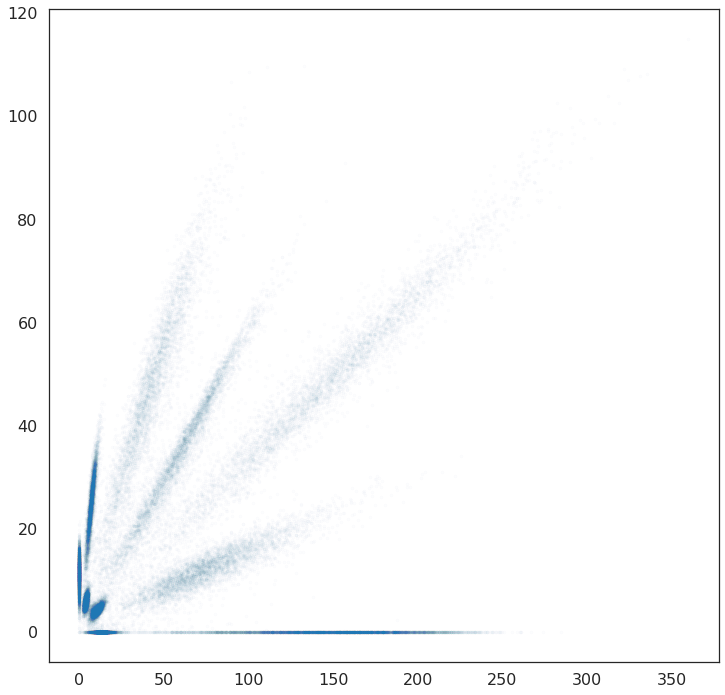

In [31]:
plt.figure(figsize=[12, 12])
plt.scatter(layer_output[:,0], layer_output[:,1], s=10, alpha=0.01)
# plt.semilogx()
# plt.semilogy()
# plt.xlim(-1,1)
# plt.ylim(1,2e2)

In [40]:
real_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
real_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

real_encoder.fit(xtr, xtr, epochs=10, batch_size=256)
print("Training performance:", real_encoder.evaluate(xtr, xtr))
# print("Test performance:", real_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 9s 184us/step - loss: 0.0840 - acc: 0.0031
Epoch 2/10
49000/49000 [==============================] - 9s 175us/step - loss: 0.0751 - acc: 0.0074
Epoch 3/10
49000/49000 [==============================] - 9s 177us/step - loss: 0.0735 - acc: 0.0130
Epoch 4/10
49000/49000 [==============================] - 8s 160us/step - loss: 0.0729 - acc: 0.0164
Epoch 5/10
49000/49000 [==============================] - 8s 171us/step - loss: 0.0721 - acc: 0.0192
Epoch 6/10
49000/49000 [==============================] - 7s 141us/step - loss: 0.0708 - acc: 0.0185
Epoch 7/10
49000/49000 [==============================] - 8s 169us/step - loss: 0.0703 - acc: 0.0183
Epoch 8/10
49000/49000 [==============================] - 7s 145us/step - loss: 0.0700 - acc: 0.0198
Epoch 9/10
49000/49000 [==============================] - 8s 160us/step - loss: 0.0698 - acc: 0.0196
Epoch 10/10
49000/49000 [==============================] - 6s 130us/step
Training performan

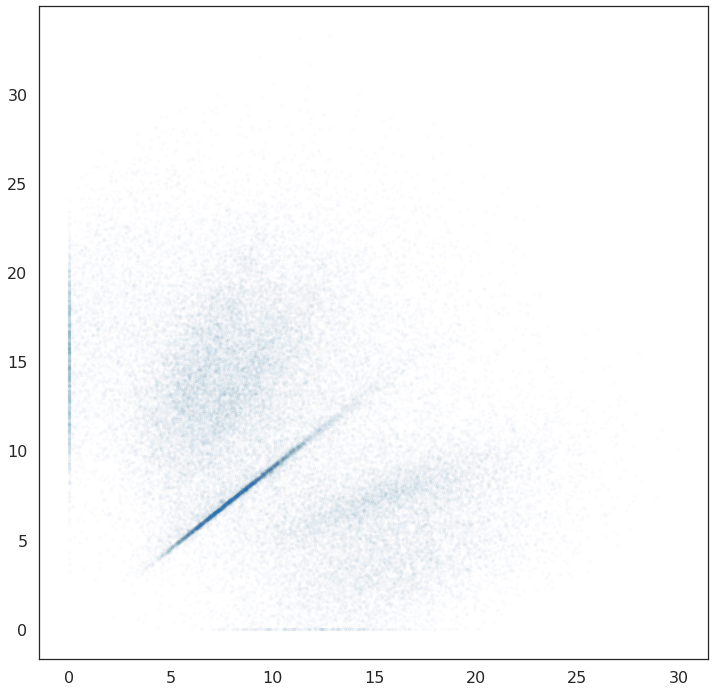

In [41]:
get_middle_layer_output = K.function([real_encoder.layers[0].input],
                                  [real_encoder.layers[2].output])
layer_output = get_middle_layer_output([xtr])[0]
plt.figure(figsize=[12, 12])
plt.scatter(layer_output[:,0], layer_output[:,1], s=10, alpha=0.01)
# plt.ylim([-0.0001, 0.0001])

In [34]:
big_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
big_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

big_encoder.fit(xtr, xtr, epochs=10, batch_size=256)
print("Training performance:", big_encoder.evaluate(xtr, xtr))
# print("Test performance:", real_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 12s 240us/step - loss: 0.0827 - acc: 0.0076
Epoch 2/10
49000/49000 [==============================] - 11s 222us/step - loss: 0.0733 - acc: 0.0134
Epoch 3/10
49000/49000 [==============================] - 9s 178us/step - loss: 0.0711 - acc: 0.0187
Epoch 4/10
49000/49000 [==============================] - 10s 206us/step - loss: 0.0701 - acc: 0.0178
Epoch 5/10
49000/49000 [==============================] - 12s 239us/step - loss: 0.0692 - acc: 0.0185
Epoch 6/10
49000/49000 [==============================] - 9s 190us/step - loss: 0.0681 - acc: 0.0186
Epoch 7/10
49000/49000 [==============================] - 11s 222us/step - loss: 0.0674 - acc: 0.0168
Epoch 8/10
49000/49000 [==============================] - 11s 225us/step - loss: 0.0666 - acc: 0.0170
Epoch 9/10
49000/49000 [==============================] - 10s 195us/step - loss: 0.0661 - acc: 0.0173
Epoch 10/10
49000/49000 [==============================] - 6s 132us/step
Training pe

In [35]:
reconstructed = big_encoder.predict(xtr)

[]

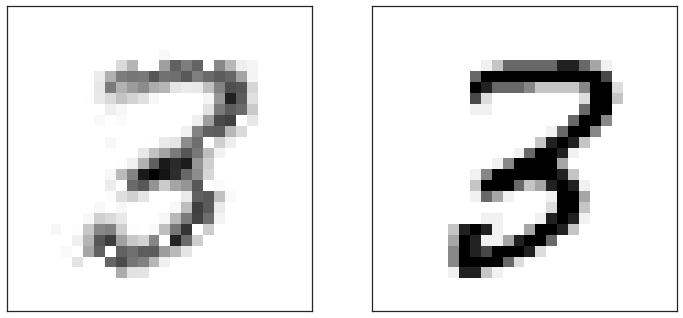

In [43]:
imsize = 28
aantal_im = len(xtr)
deze = np.random.randint(0, aantal_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(121)
number = np.reshape(reconstructed[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])

pp = plt.subplot(122)
number = np.reshape(xtr[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])


In [44]:
real_constructed = real_encoder.predict(xtr)

[]

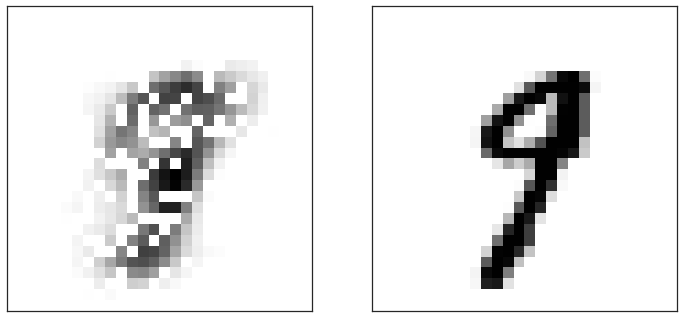

In [52]:
imsize = 28
aantal_im = len(xtr)
deze = np.random.randint(0, aantal_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(121)
number = np.reshape(real_constructed[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])

pp = plt.subplot(122)
number = np.reshape(xtr[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])


## Referenties

Python Data Science Handbook (en al het andere youtube- en blogmateriaal van auteur Jake VanderPlas, zie http://jakevdp.github.io/), geheel in notebooks op github: https://jakevdp.github.io/PythonDataScienceHandbook/

Antwoorden op al je vragen (of ze staan er al, of je hebt ze snel) op StackOverflow: https://stackoverflow.com/

Documentatie van de voor data science belangrijke paketten: https://docs.scipy.org/doc/, http://pandas.pydata.org/pandas-docs/stable/

Voor visualisatie gebruiken we matplotlib (https://matplotlib.org/ en de gallery op https://matplotlib.org/gallery/index.html), seaborn (https://seaborn.pydata.org/) en bokeh (https://bokeh.pydata.org/en/latest/).

Verder vind je op YouTube veel praatjes en workshops (vaak met materiaal op github). Let er wel op dat je redelijk recent materiaal bekijkt, sommige van deze paketten zijn nog stevig in ontwikkeling. Op YouTube kun je zoeken naar PyData, (Euro)SciPy, Pycon, Enthought en Numfocus. Dat geeft je een hele hoop materiaal.